# Anomaly Detection Exercise

In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

import datetime

import adalib

## Discrete data + probability

### Acquire

In [2]:
colnames = ["ip", "timestamp", "request_method", "status", "size",
            "destination", "request_agent"]

df_orig = pd.read_csv("http://python.zach.lol/access.log",
                      engine="python",
                      header=None,
                      index_col=False,
                      names=colnames,
                      sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                      na_values='"-"',
                      usecols=[0, 3, 4, 5, 6, 7, 8])

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

In [3]:
df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Preparation

#### Parse Datetime

In [6]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp').tz_localize(None)

#### Clean Up Text

In [7]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [8]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
df["request_agent"] = df.request_agent.str.replace(r" .+", '', 1, regex=True)

#### Convert Bytes to MB

In [10]:
# df['size_mb'] = [n/1024/1024 for n in df['size']]
df["size_mb"] = df["size"] / 1024 / 1024

In [11]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [12]:
df.request_agent.value_counts(dropna=False).reset_index()

,index,request_agent
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0,48
3,Slackbot-LinkExpanding,7
4,Slackbot,6
5,Python-urllib/3.7,1


In [13]:
df_ra_count = pd.DataFrame(df.request_agent.value_counts(dropna=False))\
                 .reset_index()\
                 .rename(columns={"index": "request_method", "request_agent": "request_agent_count"})

In [14]:
df_ra_count.head()

,request_method,request_agent_count
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0,48
3,Slackbot-LinkExpanding,7
4,Slackbot,6


In [15]:
df.request_agent.value_counts(dropna=False) / df.request_agent.count()

python-requests/2.21.0    0.858850
python-requests/2.20.1    0.136715
Mozilla/5.0               0.003434
Slackbot-LinkExpanding    0.000501
Slackbot                  0.000429
Python-urllib/3.7         0.000072
Name: request_agent, dtype: float64

In [16]:
df_ra_proba = pd.DataFrame(df.request_agent.value_counts(dropna=False) / df.request_agent.count())\
                 .reset_index()\
                 .rename(columns={"index": "request_method", "request_agent": "request_agent_proba"})

In [17]:
df_ra_proba.head()

,request_method,request_agent_proba
0,python-requests/2.21.0,0.858850
1,python-requests/2.20.1,0.136715
2,Mozilla/5.0,0.003434
3,Slackbot-LinkExpanding,0.000501
4,Slackbot,0.000429


In [18]:
df_ra = df_ra_count.merge(df_ra_proba)

In [19]:
df_ra

,request_method,request_agent_count,request_agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0,48,0.003434
3,Slackbot-LinkExpanding,7,0.000501
4,Slackbot,6,0.000429
5,Python-urllib/3.7,1,0.000072


#### Low Probabilities

In [20]:
df_ra[df_ra.request_agent_proba < 0.01]

,request_method,request_agent_count,request_agent_proba
2,Mozilla/5.0,48,0.003434
3,Slackbot-LinkExpanding,7,0.000501
4,Slackbot,6,0.000429
5,Python-urllib/3.7,1,0.000072


### Visualize

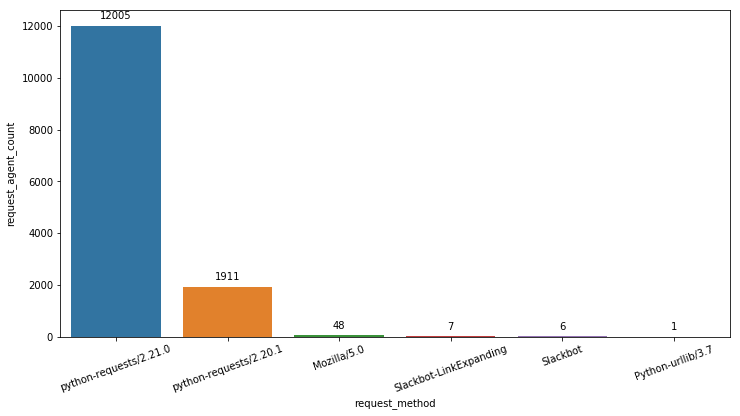

In [21]:
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=df_ra, x="request_method", y="request_agent_count", ci=None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".0f"),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha="center", va="center", xytext=(0, 10),
                   textcoords="offset points")
    plt.xticks(rotation=20)

In [22]:
df.columns

Index(['ip', 'request_method', 'status', 'size', 'destination',
       'request_agent', 'size_mb'],
      dtype='object')

In [23]:
df.index.min()

Timestamp('2019-04-16 19:34:42')

In [24]:
df[df.index < "2019-04-18"].tail()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511201,NaN,python-requests/2.21.0,0.487519
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511781,NaN,python-requests/2.21.0,0.488072
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510136,NaN,python-requests/2.21.0,0.486504
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,NaN,python-requests/2.21.0,0.486532
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0,0.000958


In [25]:
train = df["2019-04-16 19:34:42":"2019-04-17 12:55:14"]

In [26]:
df_ra = pd.DataFrame(train.request_agent.value_counts(dropna=False) / train.request_agent.count())\
          .reset_index()\
          .rename(columns={"index": "request_agent", "request_agent": "ra_prob"})

In [27]:
df_ra

,request_agent,ra_prob
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0,0.003435
3,Slackbot-LinkExpanding,0.000501
4,Slackbot,0.000429
5,Python-urllib/3.7,0.000072


In [28]:
train.request_agent.value_counts(dropna=False)

python-requests/2.21.0    12001
python-requests/2.20.1     1911
Mozilla/5.0                  48
Slackbot-LinkExpanding        7
Slackbot                      6
Python-urllib/3.7             1
Name: request_agent, dtype: int64

In [29]:
df = df.reset_index().merge(df_ra, on="request_agent", how="left")\
                .fillna(value=0).set_index("timestamp")

In [30]:
df.ra_prob.value_counts(dropna=False)

0.858809    12005
0.136754     1911
0.003435       48
0.000501        7
0.000429        6
0.000072        1
Name: ra_prob, dtype: int64

In [31]:
df[df.request_agent == "Python-urllib/3.7"]

,ip,request_method,status,size,destination,request_agent,size_mb,ra_prob
timestamp,,,,,,,,
2019-04-16 20:57:38,97.105.19.58,GET /api/v1/items&page=0 HTTP/1.1,200,162,0,Python-urllib/3.7,0.000154,0.000072


In [32]:
df[df.request_agent == "Slackbot"]

,ip,request_method,status,size,destination,request_agent,size_mb,ra_prob
timestamp,,,,,,,,
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 19:40:37,34.229.70.250,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 21:22:22,54.145.52.184,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 21:38:57,35.174.209.2,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-17 02:14:28,52.87.230.102,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429


### Conditional Probability

**Given a particular request_agent, what is the likelihood of the request_method?**

In [33]:
ra_probs = train.groupby("request_agent").size().div(len(df))

In [34]:
ra_probs

request_agent
Mozilla/5.0               0.003434
Python-urllib/3.7         0.000072
Slackbot                  0.000429
Slackbot-LinkExpanding    0.000501
python-requests/2.20.1    0.136715
python-requests/2.21.0    0.858563
dtype: float64

In [35]:
request_given_agent = pd.DataFrame(train.groupby(["request_agent", "request_method"])\
                                   .size().div(len(train))\
                                   .div(ra_probs, axis=0, level="request_agent")\
                                   .reset_index()\
                                   .rename(columns={0: "proba_request_given_agent"}))

In [36]:
request_given_agent.head()

,request_agent,request_method,proba_request_given_agent
0,Mozilla/5.0,GET / HTTP/1.1,0.104196
1,Mozilla/5.0,GET /api/V1/HiZach! HTTP/1.1,0.020839
2,Mozilla/5.0,GET /api/v1/ HTTP/1.1,0.041679
3,Mozilla/5.0,GET /api/v1//api/v1/items HTTP/1.1,0.041679
4,Mozilla/5.0,GET /api/v1//api/v1/items/next_page HTTP/1.1,0.020839


In [37]:
request_given_agent.set_index("proba_request_given_agent").sort_values(by="proba_request_given_agent")

,request_agent,request_method
proba_request_given_agent,,
0.000083,python-requests/2.21.0,GET /api/v1/ HTTP/1.1
0.000083,python-requests/2.21.0,GET /api/v1 HTTP/1.1
0.000167,python-requests/2.21.0,GET /api/v1items HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/store HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/sales/ HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/itemsitems HTTP/1.1
0.000417,python-requests/2.21.0,GET /api/v1/items/next_page HTTP/1.1
0.000583,python-requests/2.21.0,GET /api/v1/items/api/v1/items HTTP/1.1
0.000750,python-requests/2.21.0,GET /api/v1//api/v1/items HTTP/1.1


In [38]:
df = df.reset_index().merge(request_given_agent, on=["request_agent", "request_method"], how="left").fillna(value=0)\
                .set_index("timestamp")

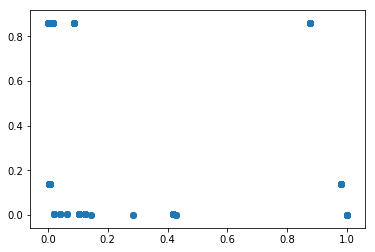

In [39]:
plt.scatter(df.proba_request_given_agent, df.ra_prob)

## Time series + EMA

**Pick a cohort and find anomalous accesses to our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.**

In [40]:
col_names = ("date", "time", "path", "uid", "cohort", "ip")
df_orig = pd.read_csv("anonymized-curriculum-access.txt", sep=" ", names=col_names)

In [41]:
df_orig.head()

,date,time,path,uid,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [42]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 6 columns):
date      233528 non-null object
time      233528 non-null object
path      233528 non-null object
uid       233528 non-null int64
cohort    219070 non-null float64
ip        233528 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 10.7+ MB


In [43]:
df = df_orig

In [44]:
# df["timestamp"] = df.date + " " + df.time

In [45]:
df.head()

,date,time,path,uid,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [46]:
df.isnull().sum()

date          0
time          0
path          0
uid           0
cohort    14458
ip            0
dtype: int64

I'm going to leave the NaNs in cohort for now because they are probably staff.

In [47]:
df.date = pd.to_datetime(df.date, utc=None)
df.date.head()

0   2018-01-26
1   2018-01-26
2   2018-01-26
3   2018-01-26
4   2018-01-26
Name: date, dtype: datetime64[ns]

In [48]:
df = df.set_index("date").sort_index()
df.head()

,time,path,uid,cohort,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [49]:
df.tail()

,time,path,uid,cohort,ip
date,,,,,
2019-04-02,11:10:19,java-ii/annotations,329,29.0,97.105.19.58
2019-04-02,11:11:18,javascript-i/introduction/working-with-data-ty...,384,31.0,97.105.19.58
2019-04-02,11:11:23,javascript-i,373,31.0,97.105.19.58
2019-04-02,11:11:25,javascript-i/introduction/working-with-data-ty...,376,31.0,97.105.19.58
2019-04-02,11:11:29,javascript-i/introduction/working-with-data-ty...,373,31.0,97.105.19.58


In [50]:
df.cohort.value_counts(dropna=False).sort_index()

 1.0      8821
 2.0        89
 4.0         4
 6.0        59
 7.0       338
 8.0      1671
 9.0         5
 11.0       79
 12.0      230
 13.0     2163
 14.0     6523
 15.0      632
 16.0      740
 17.0     1805
 18.0     1482
 19.0      901
 21.0     6465
 22.0    28268
 23.0    26655
 24.0    34485
 25.0    24681
 26.0    24088
 27.0    19255
 28.0     6163
 29.0    20471
 31.0     2997
NaN      14458
Name: cohort, dtype: int64

In [51]:
cohort = 24

Do we have every day?

In [52]:
df.index.date[-1] - df.index.date[0] + datetime.timedelta(days=1)

datetime.timedelta(days=432)

In [53]:
# len(np.unique(df.index.date))
pd.Series(df.index.date).nunique()

432

In [54]:
# idx = pd.date_range(df.index.min(), df.index.max(), freq="D")

In [55]:
# df_cohort = df[df.cohort == cohort]
df_cohort = df[df.cohort == cohort][["uid"]]
df_cohort.head()

,uid
date,
2018-05-29,182
2018-05-29,183
2018-05-29,184
2018-05-29,185
2018-05-29,186


Do we have every day for the target cohort?

In [56]:
df_cohort.index.date[-1] - df_cohort.index.date[0] + datetime.timedelta(days=1)

datetime.timedelta(days=305)

In [57]:
# len(np.unique(df_cohort.index.date))
pd.Series(df_cohort.index.date).nunique()

263

In [58]:
all_days = pd.date_range(df_cohort.index.min(), df_cohort.index.max(), freq="D")
# df_cohort = df_cohort.loc[all_days].fillna(0)
type(all_days)
df_cohort = df_cohort.loc[all_days]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [59]:
# df[df.cohort == cohort].date.agg(["min", "max"])
# df_cohort.date.agg(["min", "max"])
print(f"First: {df_cohort.index[0]}")
print(f"Last: {df_cohort.index[-1]}")

First: 2018-05-29 00:00:00
Last: 2019-03-29 00:00:00


In [60]:
date_start_train = df_cohort.index[0]
date_end_train = "2018-12-31"

print(date_start_train, "\n", date_end_train)

2018-05-29 00:00:00 
 2018-12-31


In [61]:
date_start_test = "2019-01-01"

In [62]:
train = df_cohort[:date_end_train]
test = df_cohort[date_start_test:]

print(train.index[0], "\n", train.index[-1])
print(test.index[0], "\n", test.index[-1])

2018-05-29 00:00:00 
 2018-12-31 00:00:00
2019-01-01 00:00:00 
 2019-03-29 00:00:00


#### User with most acceses

In [63]:
df_cohort.uid.value_counts(dropna=False)

 186.0    2003
 197.0    1894
 190.0    1747
 195.0    1716
 183.0    1675
 215.0    1617
 192.0    1546
 189.0    1511
 188.0    1482
 199.0    1408
 204.0    1351
 187.0    1297
 191.0    1239
 196.0    1153
 208.0    1124
 185.0    1111
 203.0    1083
 193.0    1026
 184.0    1023
 207.0     969
 194.0     927
 205.0     886
 182.0     856
 201.0     762
 200.0     760
 198.0     705
 206.0     469
 249.0     434
 202.0     365
 251.0     113
 253.0      97
 250.0      68
 278.0      68
NaN         42
Name: uid, dtype: int64

In [64]:
train.uid.value_counts(dropna=False)

 197.0    1791
 190.0    1747
 186.0    1747
 195.0    1672
 183.0    1659
 215.0    1609
 192.0    1546
 188.0    1482
 199.0    1408
 189.0    1401
 204.0    1323
 187.0    1265
 191.0    1239
 196.0    1153
 208.0    1124
 203.0    1083
 185.0    1046
 184.0    1023
 193.0    1017
 207.0     969
 194.0     927
 205.0     886
 182.0     856
 200.0     760
 201.0     707
 198.0     624
 206.0     469
 249.0     378
 202.0     365
 251.0     113
 253.0      97
 250.0      68
 278.0      49
NaN         15
Name: uid, dtype: int64

In [65]:
test.uid.value_counts(dropna=False)

 186.0    256
 189.0    110
 197.0    103
 198.0     81
 185.0     65
 249.0     56
 201.0     55
 195.0     44
 187.0     32
 204.0     28
NaN        27
 278.0     19
 183.0     16
 193.0      9
 215.0      8
Name: uid, dtype: int64

### Total Accesses for All Users

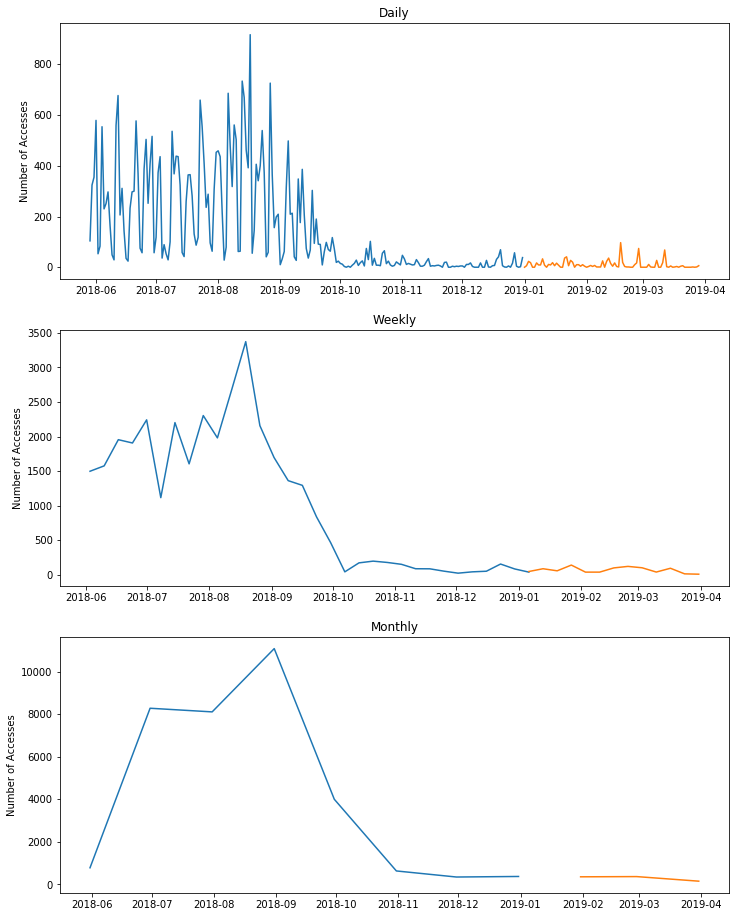

In [66]:
freqs = {"D": "Daily", "W": "Weekly", "M": "Monthly"}
plt.figure(figsize=(12, 16))
for i, freq in enumerate(freqs):
    plt.subplot(3, 1, i + 1)
    plt.plot(train.resample(freq).uid.count())
    plt.plot(test.resample(freq).uid.count())
    plt.ylabel("Number of Accesses")
    plt.title(freqs[freq])
plt.show()

### Average Accesses for Each User

In [67]:
train_avg_access = train.reset_index().groupby("date").uid.count().div(train.reset_index().groupby("date").uid.nunique())
test_avg_access = test.reset_index().groupby("date").uid.count().div(test.reset_index().groupby("date").uid.nunique())

print(train_avg_access.head())
print(test_avg_access.head())

date
2018-05-29     4.000000
2018-05-30    12.000000
2018-05-31    13.148148
2018-06-01    21.444444
2018-06-02     8.833333
Name: uid, dtype: float64
date
2019-01-01          NaN
2019-01-02     6.000000
2019-01-03     7.666667
2019-01-04    18.000000
2019-01-05          NaN
Name: uid, dtype: float64


Fill in the missing days with 0

In [68]:
all_days = pd.date_range(train_avg_access.index.min(), train_avg_access.index.max(), freq="D")

# df_cohort = df_cohort.loc[all_days].fillna(0)
train_avg_access = train_avg_access.loc[all_days].fillna(0)

In [69]:
all_days = pd.date_range(test_avg_access.index.min(), test_avg_access.index.max(), freq="D")

# df_cohort = df_cohort.loc[all_days].fillna(0)
test_avg_access = test_avg_access.loc[all_days].fillna(0)

In [70]:
test_avg_access.isnull().sum()

0

In [71]:
train_avg_access.resample("W").mean().head()

2018-06-03    11.287654
2018-06-10     9.327551
2018-06-17    11.829728
2018-06-24    12.462033
2018-07-01    14.280830
Freq: W-SUN, Name: uid, dtype: float64

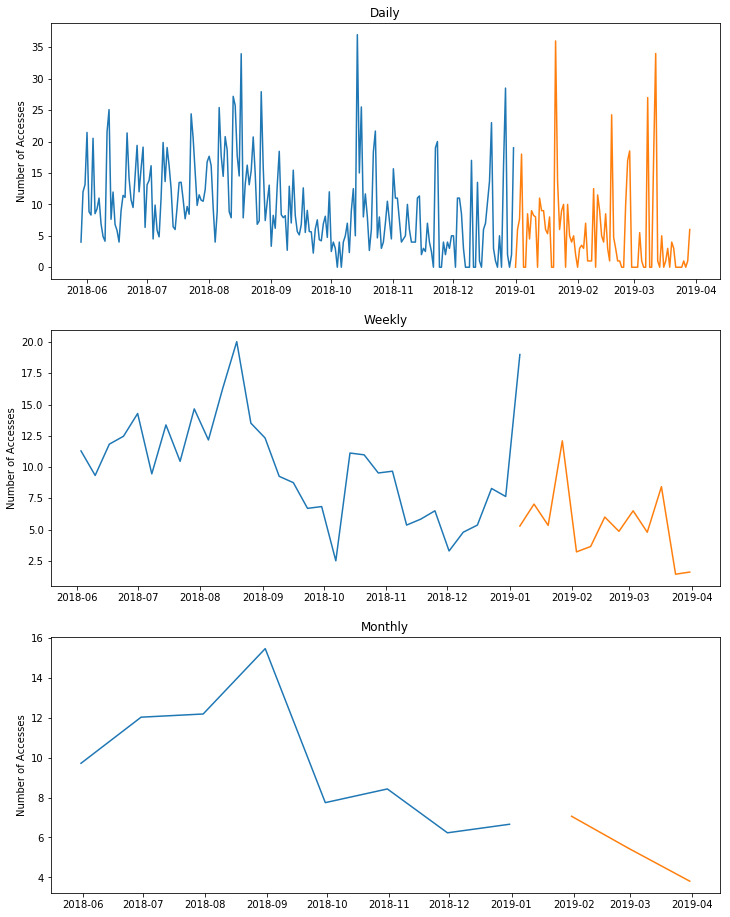

In [72]:
freqs = {"D": "Daily", "W": "Weekly", "M": "Monthly"}
plt.figure(figsize=(12, 16))
for i, freq in enumerate(freqs):
    plt.subplot(3, 1, i + 1)
    plt.plot(train_avg_access.resample(freq).mean())
    plt.plot(test_avg_access.resample(freq).mean())
    plt.ylabel("Number of Accesses")
    plt.title(freqs[freq])
plt.show()

### SMA- Simple Moving Average

In [73]:
short_rolling = train_avg_access.rolling(window=14).mean()

long_rolling = train_avg_access.rolling(window=28).mean()

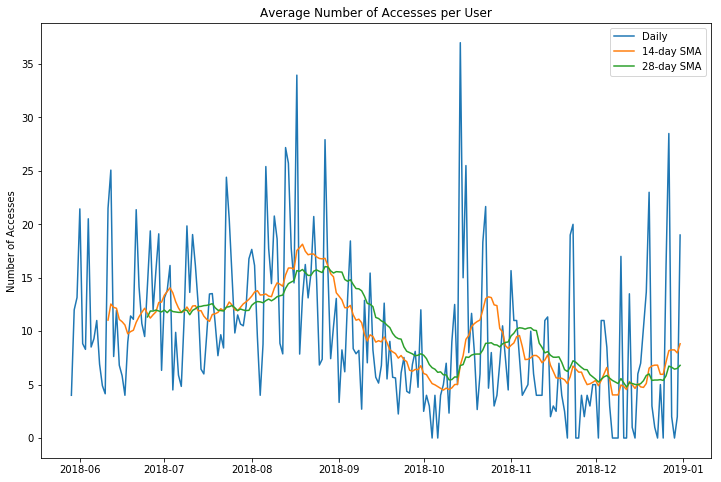

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_avg_access, label="Daily")
ax.plot(short_rolling, label="14-day SMA")
ax.plot(long_rolling, label="28-day SMA")

ax.legend(loc="best")
ax.set_ylabel("Number of Accesses")
plt.title("Average Number of Accesses per User")

plt.show()

### Exponential Moving Average

In [75]:
train_avg_access.head()

2018-05-29     4.000000
2018-05-30    12.000000
2018-05-31    13.148148
2018-06-01    21.444444
2018-06-02     8.833333
Freq: D, Name: uid, dtype: float64

In [76]:
ema_short = train_avg_access.ewm(span=14, adjust=False).mean()
ema_short.head()

2018-05-29    4.000000
2018-05-30    5.066667
2018-05-31    6.144198
2018-06-01    8.184230
2018-06-02    8.270778
Freq: D, Name: uid, dtype: float64

In [77]:
ema_long = train_avg_access.ewm(span=28, adjust=False).mean()
ema_long.head()

2018-05-29    4.000000
2018-05-30    4.551724
2018-05-31    5.144581
2018-06-01    6.268709
2018-06-02    6.445580
Freq: D, Name: uid, dtype: float64

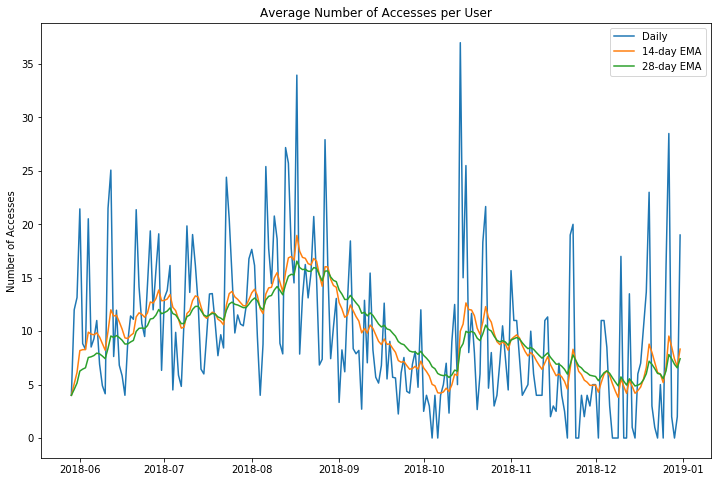

In [78]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_avg_access, label="Daily")
ax.plot(ema_short, label="14-day EMA")
ax.plot(ema_long, label="28-day EMA")

ax.legend(loc="best")
ax.set_ylabel("Number of Accesses")
plt.title("Average Number of Accesses per User")

plt.show()

### Compare SMA and EMA

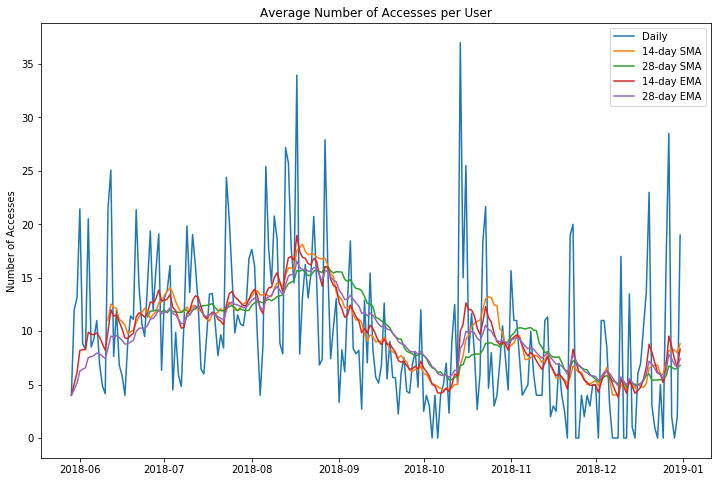

In [79]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_avg_access, label="Daily")
ax.plot(short_rolling, label="14-day SMA")
ax.plot(long_rolling, label="28-day SMA")
ax.plot(ema_short, label="14-day EMA")
ax.plot(ema_long, label="28-day EMA")

ax.legend(loc="best")
ax.set_ylabel("Number of Accesses")
plt.title("Average Number of Accesses per User")

plt.show()

In [80]:
yhat = pd.DataFrame(dict(actual=test_avg_access))
yhat.head()

,actual
2019-01-01,0.000000
2019-01-02,6.000000
2019-01-03,7.666667
2019-01-04,18.000000
2019-01-05,0.000000


### Forecast using EMA

In [81]:
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std() * 3
lb = midband - ema_long[-24:-1].std() * 3

yhat["moving_avg_forecast"] = midband

**Compute %b for each record**

In [82]:
# compute the absolute error
yhat["error"] = abs(yhat.actual - yhat.moving_avg_forecast)

yhat["pct_b"] = (yhat.actual - lb) / (ub - lb)

**Get the anomalies**

In [83]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-01-04,18.000000,7.42193,10.578070,2.518132
2019-01-13,11.000000,7.42193,3.578070,1.182640
2019-01-21,36.000000,7.42193,28.578070,5.952253
2019-01-22,13.666667,7.42193,6.244736,1.691399
2019-02-09,12.500000,7.42193,5.078070,1.468817
2019-02-11,11.500000,7.42193,4.078070,1.278032
2019-02-18,24.250000,7.42193,16.828070,3.710535
2019-02-26,17.000000,7.42193,9.578070,2.327347
2019-02-27,18.500000,7.42193,11.078070,2.613524
2019-03-08,27.000000,7.42193,19.578070,4.235192


### Evaluate Forecast

Put this in adalib and fix

In [84]:
def plot_data_and_predictions(train, test, predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(train, test, predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        plt.title(f"{train.name}")

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(f"{train.name}\n{label}")

    plt.legend(loc='best')
    plt.show()

Fix this error

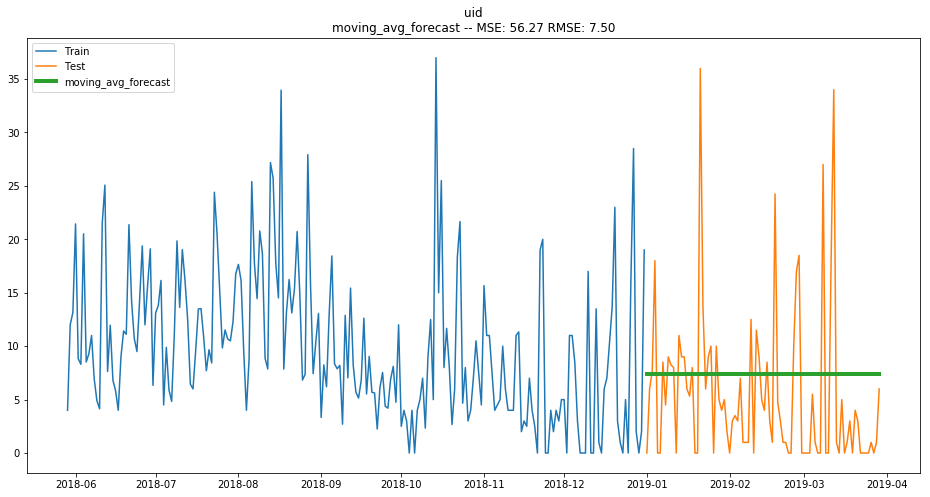

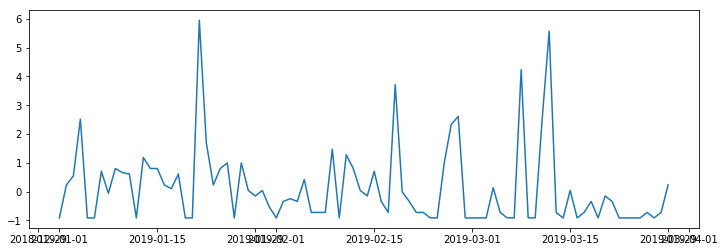

In [85]:
plot_and_eval(train_avg_access, test_avg_access, yhat.moving_avg_forecast, yhat.actual)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Use Bollinger Bands for each user

## Clustering - DBSCAN

In [86]:
df_customers_orig = pd.read_csv("customers.csv")
df_customers_orig.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [87]:
df_customers = df_customers_orig[["Grocery", "Frozen"]]
df_customers.head()

,Grocery,Frozen
0,7561,214
1,9568,1762
2,7684,2405
3,4221,6404
4,7198,3915


In [88]:
np_array = df_customers.values.astype("float32", copy=False)

In [89]:
np_array.shape

(440, 2)

In [90]:
np_array[:5]

array([[7561.,  214.],
       [9568., 1762.],
       [7684., 2405.],
       [4221., 6404.],
       [7198., 3915.]], dtype=float32)

In [91]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[:5]

array([[-0.0411149 , -0.5893672 ],
       [ 0.17031837, -0.27013618],
       [-0.0281571 , -0.13753572],
       [-0.3929769 ,  0.68714434],
       [-0.07935619,  0.17385884]], dtype=float32)

In [92]:
dbsc = DBSCAN(eps=0.5, min_samples=15).fit(np_array)
print(dbsc)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=15, n_jobs=None, p=None)


In [93]:
labels = dbsc.labels_
print(f"labels = {labels}")
print(labels.shape)

labels = [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0 -1 -1  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1

In [94]:
core_samples = np.zeros_like(labels, dtype=bool)
print(core_samples)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [95]:
core_samples[dbsc.core_sample_indices_] = True
print(core_samples)
print(core_samples.sum())

[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False  True  True  True  True  True  True False  True  True  True
  True False  True  True  True False  True  True  True  True  True False
  True False  True  True  True False  True  True  True  True  True  True
  True False False  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  T

In [96]:
df_customers["labels"] = labels

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


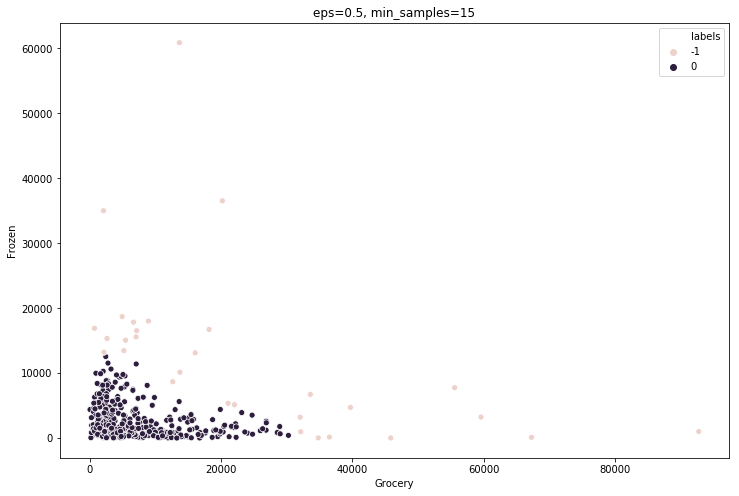

In [97]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df_customers.Grocery, df_customers.Frozen, hue=df_customers.labels)
plt.title("eps=0.5, min_samples=15")
plt.show()

How many anomalies are there?

In [98]:
(~core_samples).sum()

47

The outliers

In [99]:
df_customers_orig[~core_samples]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
10,2,3,3366,5403,12974,4400,5977,1744
23,2,3,26373,36423,22019,5154,4337,16523
47,2,3,44466,54259,55571,7782,24171,6465
49,2,3,4967,21412,28921,1798,13583,1163
56,2,3,4098,29892,26866,2616,17740,1340
61,2,3,35942,38369,59598,3254,26701,2017
65,2,3,85,20959,45828,36,24231,1423
71,1,3,18291,1266,21042,5373,4173,14472
73,2,3,19899,5332,8713,8132,764,648
77,2,3,12205,12697,28540,869,12034,1009


In [100]:
dbsc2, cs2 = adalib.dbscan_model(np_array, eps=0.75, min_samples=5)

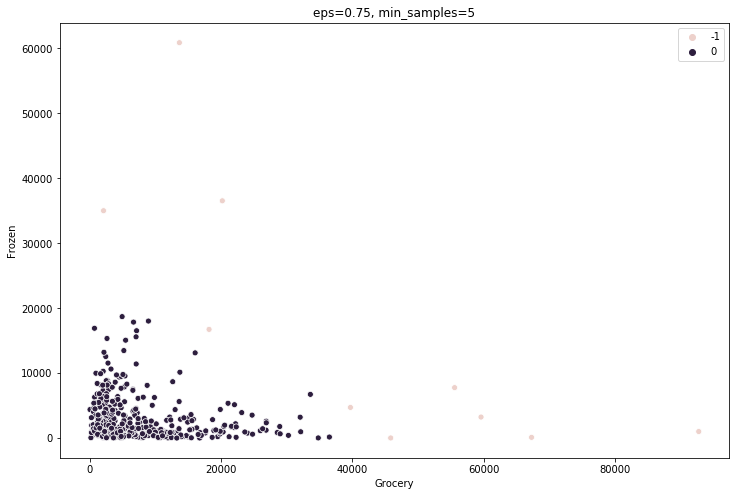

In [101]:
adalib.dbscan_visualize(df_customers.Grocery, df_customers.Frozen, dbsc2)

what are the outliers

In [102]:
df_customers_orig[~cs2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
47,2,3,44466,54259,55571,7782,24171,6465
61,2,3,35942,38369,59598,3254,26701,2017
65,2,3,85,20959,45828,36,24231,1423
85,2,3,16117,46197,92780,1026,40827,2944
93,1,3,11314,3090,2062,35009,71,2698
181,1,3,112151,29627,18148,16745,4948,8550
183,1,3,36847,43950,20170,36534,239,47943
211,2,1,12119,28326,39694,4736,19410,2870
216,2,1,2532,16599,36486,179,13308,674
251,2,1,6134,23133,33586,6746,18594,5121


anything in common?

In [103]:
df_customers_orig[~cs2].groupby(["Channel", "Region"])[["Channel", "Region"]].count()

Channel  Region
Channel Region                 
1       2             1       1
        3             4       4
2       1             3       3
        2             1       1
        3             4       4

### fresh, frozen, deli

In [104]:
df_customers = df_customers_orig[["Fresh", "Frozen", "Delicassen"]]

In [105]:
np_array = df_customers.values.astype("float32", copy=False)
np_array[:10]

array([[12669.,   214.,  1338.],
       [ 7057.,  1762.,  1776.],
       [ 6353.,  2405.,  7844.],
       [13265.,  6404.,  1788.],
       [22615.,  3915.,  5185.],
       [ 9413.,   666.,  1451.],
       [12126.,   480.,   545.],
       [ 7579.,  1669.,  2566.],
       [ 5963.,   425.,   750.],
       [ 6006.,  1159.,  2098.]], dtype=float32)

In [106]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)

In [107]:
dbsc3, cs3 = adalib.dbscan_model(np_array, eps=0.5, min_samples=5)

In [108]:
(~cs3).sum()

63

**Visualize outliers**

TypeError: Cannot cast Index to dtype <class 'float'>

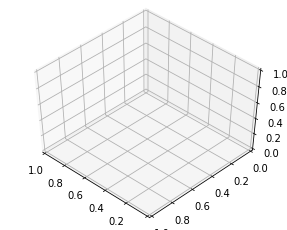

In [109]:
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df_customers.Fresh, df_customers.Frozen, df_customers.Delicassen,
           c=df_customers.columns.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Deli')

ax.set_title(title)
ax.dist = 12